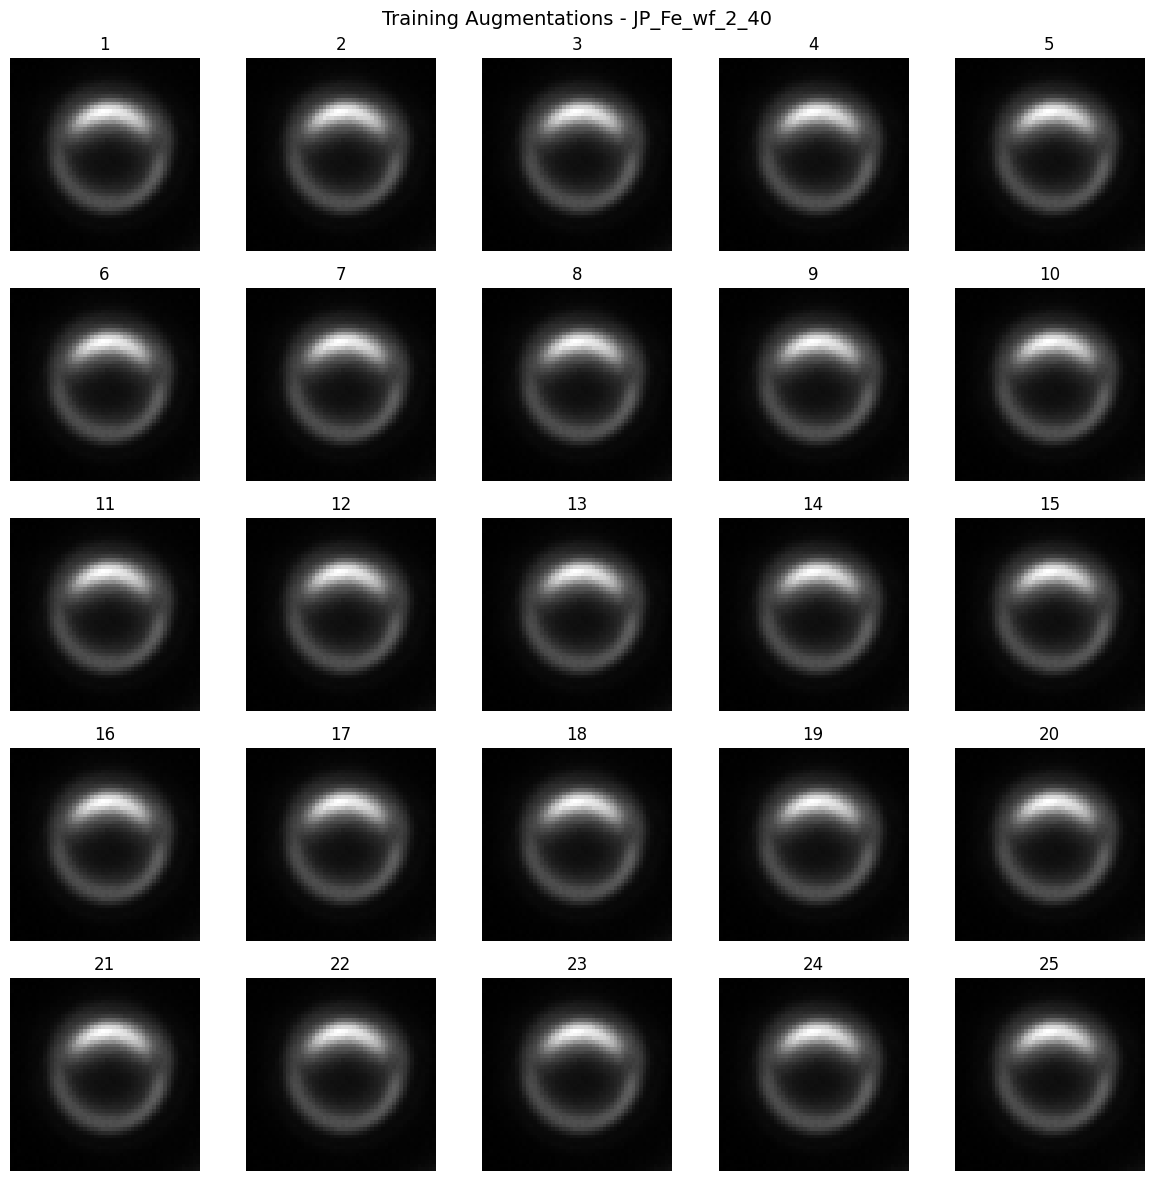

In [3]:
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt

sys.path.insert(0, os.path.dirname(os.path.abspath('.')))

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

particle_type = config['samples'][0]
data_dir = os.path.join('..', config['data_dir'])

sample_path = None
for ext in ['jpg', 'png']:
    candidate = os.path.join(data_dir, 'Samples', particle_type, f'{particle_type}.{ext}')
    if os.path.exists(candidate):
        sample_path = candidate
        break

training_image = np.array(dt.LoadImage(sample_path).resolve()).astype(np.float32)
if len(training_image.shape) == 3 and training_image.shape[-1] == 3:
    training_image = np.dot(training_image[..., :3], [0.299, 0.587, 0.114])
if len(training_image.shape) == 2:
    training_image = training_image[..., np.newaxis]

training_pipeline = (
    dt.Value(training_image)
    #>> dt.AveragePooling(ksize=(3, 3, 3))
    #>> dt.AveragePooling(ksize=(config['downsample'], config['downsample'], 3))
    >> dt.Affine(
        scale=lambda: np.random.uniform(config['scale_min'], config['scale_max']),
        rotate=lambda: 2*np.pi*np.random.uniform(config['rotation_range'][0], config['rotation_range'][1]),
        translate=lambda: np.random.uniform(config['translation_range'][0], config['translation_range'][1], 2),
        mode='constant'
    )
    #>> dt.Gaussian(sigma=lambda: np.random.uniform(config['sigma_min'], config['sigma_max']))
    >> dt.Multiply(lambda: np.random.uniform(config['mul_min'], config['mul_max']))
    >> dt.Add(lambda: np.random.uniform(config['add_min'], config['add_max']))
)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    training_pipeline.update()
    sample = training_pipeline.resolve()
    ax.imshow(sample.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'{i+1}')
plt.suptitle(f'Training Augmentations - {particle_type}', fontsize=14)
plt.tight_layout()
plt.show()
